# Tests and Examples for  *pred_help*
### Classifier, Results , NamedTuples and help functions

In [1]:
# Notebook setup (initially %load(ed) from 'notebook_setup.py')
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Set these (even tho they get re-set) to placate PyCharm
data_dir = None
models_dir = None

import numpy as np
from   pathlib import Path
# mcs utilities and helpers
from   ms_util import *

#Project Setup - Names & Commonly Used Values
project_name   = 'test_pred_help'   # Used as prefix for several derived names below
model_name     = 'resnet50'
model_arch     = 'Resnet50'   # Resnet50 , Resnet34, etc ...
img_size       = 300
batch_size     = 32

%run -i {user_lib}/finish_setup.py --show Proj

data_dir        =  /Volumes/ArielD/storage/data
data_root       =  /Volumes/ArielD/storage
proj_data_dir   =  /Volumes/ArielD/storage/data/test_pred_help
project_name    =  test_pred_help
proj_data_dir   =  /Volumes/ArielD/storage/data/test_pred_help
proj_dir        =  /Users/mcsieber/storage/notebooks/test_pred_help
models_dir      =  /Volumes/ArielD/storage/data/test_pred_help/models
model_name      =  resnet50
model_arch      =  Resnet50
img_size        =  300
batch_size      =  32



### Additional Setup

In [2]:
from PIL import Image
from PIL import ImageOps
from pred_help import *
from coreml_help import *
mlmodels_dir = data_dir/'mlmodels'  # Where to find downloaded CoreML models
resize_method = Image.NEAREST       # How to resample images when they are resized

#### Get test images

In [3]:
test_root     = data_root/'data'
test_data_dir = data_dir/'test'
imagenet_dir  = data_dir/'imagenet'
imagenet_path = imagenet_dir/'img_net_labels.txt'
#
dogcat_dir    = test_root/'dogscats/large/valid-large'
fruit_dir     = test_root/'food_poc/data'
food_dir      = Path('/Volumes/ArielD/storage/data/food/images')
#
img_per_dir = 2 # Get this many images per directory
max_sample  = 400    # Max sample range (set limit in case it is a huge directory)
#
t0 = get_rand_images(food_dir,   n_images=img_per_dir, search_limit=max_sample)
t1 = get_rand_images(dogcat_dir, n_images=img_per_dir, search_limit=max_sample)
t2 = get_rand_images(fruit_dir,  n_images=img_per_dir, search_limit=max_sample)
test_imgs = t0+t1+t2
#
vimg_path  = Path('/Volumes/ArielD/storage/data/food_poc/data/apples/apple_029.jpg')
vimg300    = ImageOps.fit(Image.open(vimg_path),(300,300), method=resize_method, centering=(0.5,0.4))
vimg224    = ImageOps.fit(Image.open(vimg_path),(224,224), method=resize_method, centering=(0.5,0.4))
print(f"{len(test_imgs)} test images")
pp((dogcat_dir, food_dir,fruit_dir))

22 test images
dogcat_dir     =  PosixPath('/Volumes/ArielD/storage/data/dogscats/large/valid-large')
food_dir       =  PosixPath('/Volumes/ArielD/storage/data/food/images')
fruit_dir      =  PosixPath('/Volumes/ArielD/storage/data/food_poc/data')


**Imagenet Class Labels** - Load the class labels from a disk file .These are the [1000 class labels](https://s3.amazonaws.com/onnx-model-zoo/synset.txt) for ImageNet.

In [4]:
with open(imagenet_path, 'r') as list_ : 
    inet_labels = [line.rstrip() for line in list_ ]

**`imageRepo`** - Examine `imageRepo` named tuple

In [5]:
pp((type(imagenet), imagenet.mean, imagenet.std, imagenet.labels_url))

type(imagenet  = 
{   'count': "<method 'count' of 'tuple' objects>",
    'index': "<method 'index' of 'tuple' objects>",
    'labels_url': '<property object at 0x11e08d5e8>',
    'mean': '<property object at 0x11e08d278>',
    'std': '<property object at 0x11e08d598>'}

imagenet.mean  = 
[0.485, 0.456, 0.406]

imagenet.std   = 
[0.229, 0.224, 0.225]

 imagenet.labels_url =  'https://s3.amazonaws.com/onnx-model-zoo/synset.txt'


For CoreML from ONNX, calculate scale and bias to reproduce normalization

In [6]:
mean = np.array(imagenet.mean)
std  = np.array(imagenet.std)

ppargs = dict(
    image_scale= 1/(255.0*std.mean()),
    red_bias   = - mean[0]/std[0],
    green_bias = - mean[1]/std[1],
    blue_bias  = - mean[2]/std[2]
)
ppargs

{'image_scale': 0.01735207357279195,
 'red_bias': -2.1179039301310043,
 'green_bias': -2.0357142857142856,
 'blue_bias': -1.8044444444444445}

### *Pred* functions examples
(And instantiate models for later tests)

**ONNX** - Load [ONNX Resnet50(v2)](https://s3.amazonaws.com/onnx-model-zoo/resnet/resnet50v2/resnet50v2.tar.gz) model and check that it works. This model was downloaded from the [ONNX Model Zoo](https://github.com/onnx/models)

In [7]:
import onnx
import onnxruntime as ort

onnxm_name   = 'resnet50.onnx'
onnxm_path   = data_dir/'onnx/resnet50v2'/onnxm_name ; onnxm_path
onnxm        = onnx.load(onnxm_path)
onnx.checker.check_model(onnxm)

onnx_rt  = ort.InferenceSession(onnxm_path.as_posix())
pred     = pred_for_onnx(onnx_rt,vimg300,labels=inet_labels)

**`ImagePrediction`** - Examime the named tuple

In [8]:
pp((type(pred), pred.topI, pred.topP, pred.topL))

type(pred      = 
{   'count': "<method 'count' of 'tuple' objects>",
    'index': "<method 'index' of 'tuple' objects>",
    'topI': '<property object at 0x11e084ef8>',
    'topL': '<property object at 0x11e08d1d8>',
    'topP': '<property object at 0x11e08d188>'}

pred.topI      = 
array([948, 950, 957])

pred.topP      = 
array([0.1882, 0.1052, 0.098 ], dtype=float32)

 pred.topL     = 
[   'n07742313 Granny Smith',
    'n07747607 orange',
    'n07768694 pomegranate']



**`show_pred`** Demonstrate the `show_pred` function

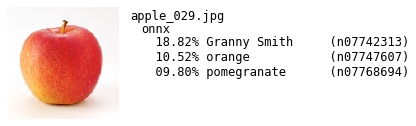

In [9]:
show_pred(vimg_path,pred,model_id='onnx');

**Torch** - Load and check a standard Torch Resnet50

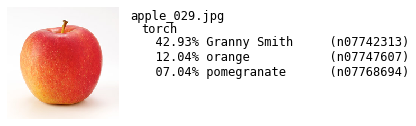

In [10]:
import torch
import torchvision

torchm_name = 'torch.pth'
torchm_path = models_dir/torchm_name
torchm      = torchvision.models.resnet50(pretrained=True)
torchm.eval()  # Must set to evaluation mode to generate predictions

pred = pred_for_torch(torchm,vimg300,labels=inet_labels)
show_pred(vimg_path,pred, model_id='torch');

**CoreML** - Load and check a standard CoreML Resnet50 model

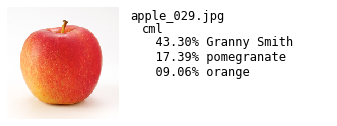

In [11]:
coreml_name = 'Resnet50.mlmodel'
coreml_path = mlmodels_dir/'Resnet50'/coreml_name
cml  = cm.MLModel(coreml_path.as_posix())

pred = pred_for_coreml(cml,vimg224)
show_pred(vimg_path,pred, model_id='cml');

## Predictions
For each of the test images, generate a prediction from each of the models and save the results.

In [12]:
models_params = { 
        'torch': PredParams(func=pred_for_torch, runtime=torchm, imgsize=300, labels=inet_labels),
        'onnx' : PredParams(func=pred_for_onnx,  runtime=onnx_rt,imgsize=300, labels=inet_labels),
        'cml'  : PredParams(func=pred_for_coreml,runtime=cml,    imgsize=224, labels= None)
    # additional models would go here
}

**`PredParams`** - Examine the `PredParams` named tuple

In [13]:
t = models_params['torch'] #torch_pred_params

In [14]:
pp((type(t), t.func, t.imgsize, t.index, len(t.labels), type(t.runtime)))

type(t         = 
{   'count': "<method 'count' of 'tuple' objects>",
    'func': '<property object at 0x11e08d728>',
    'imgsize': '<property object at 0x11e08da98>',
    'index': "<method 'index' of 'tuple' objects>",
    'labels': '<property object at 0x11e08dae8>',
    'runtime': '<property object at 0x11e08da48>'}

t.func         =  <function pred_for_torch at 0x11e0912f0>
t.imgsize      =  300
t.index        =  <built-in method index of PredParams object at 0x125a7c7d8>
len(t.labels)  =  1000
 type(t.runtime =  <class 'torchvision.models.resnet.ResNet'>


### Classifier 
Create and examine a`Classifier`

In [15]:
classifier = Classifier(params=models_params,top_count=3)
c = classifier
pp((c.model_list,c.model_dict,len(c.pred_params),c.num_models,c.num_imgs,c.resize_method, c.top_count))

c.model_list   = 
['torch', 'onnx', 'cml']

c.model_dict   = 
{'cml': 2, 'onnx': 1, 'torch': 0}

len(c.pred_params) =  3
c.num_models   =  3
c.num_imgs     =  8
c.resize_method =  0
 c.top_count   =  3


#### Classifier - Demonstrate prediction generation and capture
Get predictions on each test image from all models and save the results  

In [16]:
classifier.classify(test_imgs);

0 of 22 processed, most recent is roots_086.jpg
16 of 22 processed, most recent is burger_158.jpg
Total of 22 images processed


In [17]:
pp((c.num_imgs, len(c.top_probs), len(c.top_classes), len(c.results), c.stat_int))

c.num_imgs     =  22
len(c.top_probs) =  3
len(c.top_classes) =  3
len(c.results) =  22
 c.stat_int    =  16


### Results
Create `Results` from classifier and examine

In [18]:
results = Results(classifier)
r = results

In [19]:
pp((r.resize_method, len(r.results),r.results_len, r.fontsize, r.fontfamily, r.pred2show, r.model_list, r.figsize, r.imgsize))

r.resize_method =  0
len(r.results) =  22
r.results_len  =  22
r.fontsize     =  12
r.fontfamily   =  'monospace'
r.pred2show    =  2
r.model_list   = 
['torch', 'onnx', 'cml']

r.figsize      = 
(3.0, 3.5)

 r.imgsize     = 
(224, 224)



**Results** - Demonstrate methods

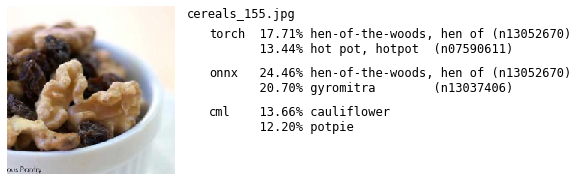

In [20]:
results.show(12)

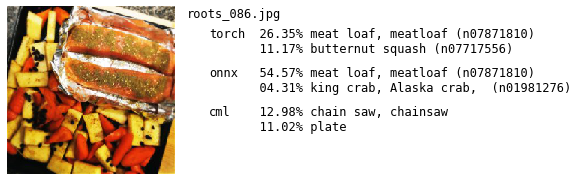

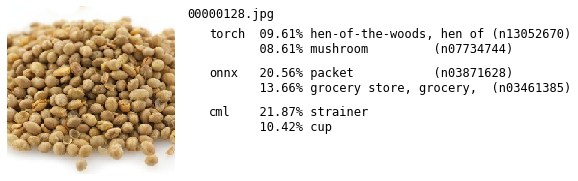

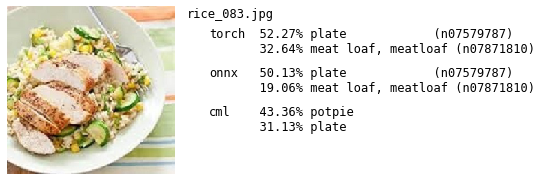

In [21]:
results.show([0,2,7])


Showing results [1, 3, 13, 17, 18] 
  and top 2 probabilities for each model


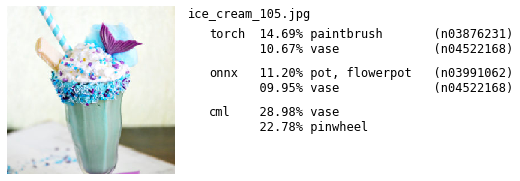

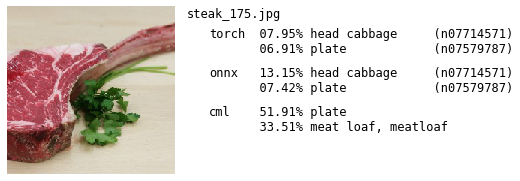

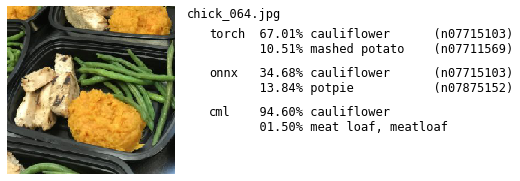

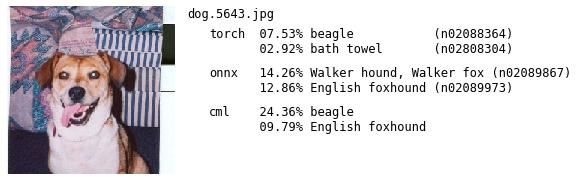

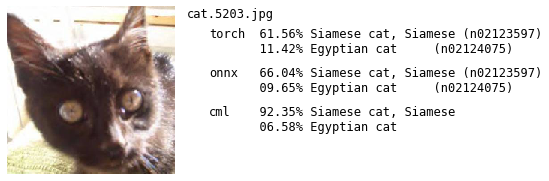

In [22]:
results.show_random()

#### Agreement
- Show agreement counts between specified model and the rest.  
- Show best and worst agreement between two models.   
- Show the agreement matrix

In [23]:
r.show_agreement('torch')

torch   and torch   agree on   22 of   22 or 100.00%
torch   and onnx    agree on   16 of   22 or 72.73%
torch   and cml     agree on   12 of   22 or 54.55%


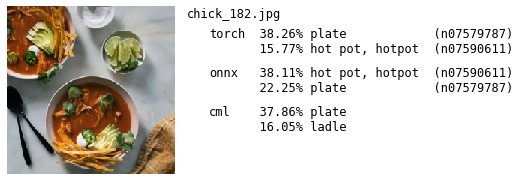

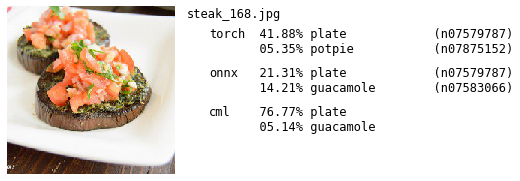

In [24]:
r.show(r.best_worst('torch','cml'))

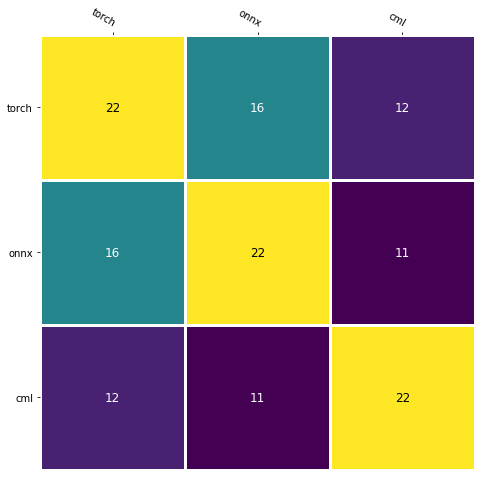

In [25]:
r.agree_matrix()

#### Certainty
Return most and least certain for all models

In [26]:
ml = r.most_least(); ml

[[11, 17], [11, 1], [11, 0]]

torch - most certain, least certain


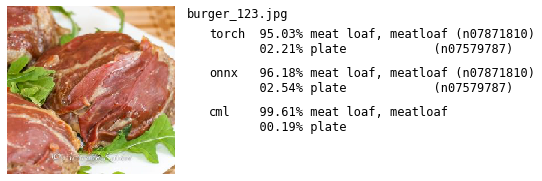

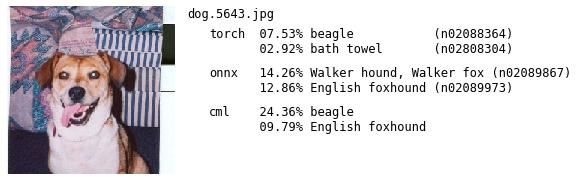

onnx - most certain, least certain


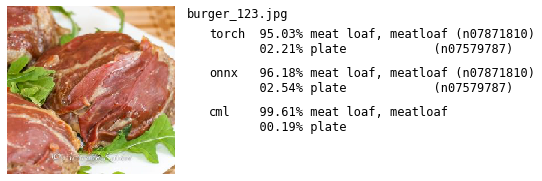

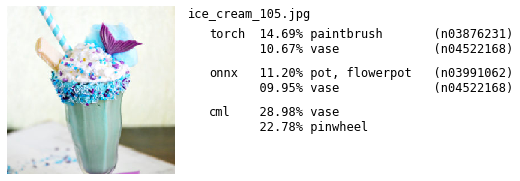

cml - most certain, least certain


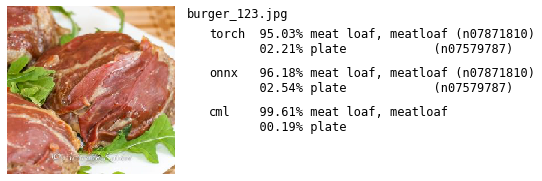

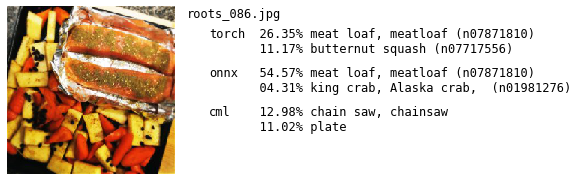

In [27]:
for i, il in enumerate(ml):
    print(f"{r.i2m(i)} - most certain, least certain")
    r.show(il)